# Pneumonia Detection (Resent_V1_50 Model)

In [1]:
#Data Manupalation Imports
import numpy as np
import pandas as pd

#Image Vizualization Imports
import os
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#Confusion Matrix Imports
from sklearn import metrics
import seaborn as sns

#TensorFlow Imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Tensorflow Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Establish the paths
parent_path='/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'
train_path='/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_path='/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
val_path='/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

#View random Image
def view_random_image(folder,typ):
    path='/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'+folder+'/'+typ+'/'
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    print(random_image.max())
    plt.imshow(random_image)
    plt.title("File Name:" + rand)
    
#Loss Curve plot
def loss_curve_plot(df):
    history=df.history
    val_accuracy=history["val_accuracy"]
    val_loss=history["val_loss"]
    train_accuracy=history["accuracy"]
    train_loss=history["loss"]
    
    #Accuracy Plot
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()
    
    #Loss Plot
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Loss Curves")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
#Confusion Matrix
def confusion_matrix_plot(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot = True, cmap = "Blues", annot_kws = {"size": 16})

## Resent_V1_50 Model

In [2]:
#Scaling the Image
augmenter=ImageDataGenerator(rescale=1./255)
train_data=augmenter.flow_from_directory(directory=train_path, batch_size=32, target_size = (150,150), class_mode="binary", seed=42, shuffle=True)
test_data=augmenter.flow_from_directory(directory=test_path, batch_size=32, class_mode="binary", target_size = (150,150), seed=42, shuffle=True)
val_data=augmenter.flow_from_directory(directory=val_path, batch_size=32, class_mode="binary", target_size = (150,150), seed=42, shuffle=True)

#Load the Resenet_V2_50_classification model from TensorFlow Hub
resentV_base=hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5",
                              trainable=False,
                              input_shape=(150,150,3))

#Tuning the Model
resentV_model = tf.keras.Sequential([
    resentV_base,
    Flatten(),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])

#Model Summary
resentV_model.summary()

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25612201  
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 batch_normalization (BatchN  (None, 1001)             4004      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 1002      
                                                                 
Total params: 25,617,207
Trainable params: 3,004
Non-trainable params: 25,614,203
_________________________________________________

## Compile and Fit

In [3]:
#Callbacks
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 6)

#Comiple and fit resnetV_model
resentV_model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(lr=0.00001, decay=1e-6), metrics=["accuracy"])
resentV_history = resentV_model.fit(x=train_data, validation_data=val_data, steps_per_epoch = len(train_data), epochs = 20, callbacks=[checkpointer, early_stopping])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 1.0229 - accuracy: 0.4340
Epoch 1: val_loss improved from inf to 0.98218, saving model to chestmodel.hdf5
163/163 [==============================] - 105s 592ms/step - loss: 1.0229 - accuracy: 0.4340 - val_loss: 0.9822 - val_accuracy: 0.4375
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 0.8683 - accuracy: 0.5054
Epoch 2: val_loss improved from 0.98218 to 0.88684, saving model to chestmodel.hdf5
163/163 [==============================] - 67s 411ms/step - loss: 0.8683 - accuracy: 0.5054 - val_loss: 0.8868 - val_accuracy: 0.4375
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.7493 - accuracy: 0.5767
Epoch 3: val_loss improved from 0.88684 to 0.82241, saving model to chestmodel.hdf5
163/163 [==============================] - 66s 402ms/step - loss: 0.7493 - accuracy: 0.5767 - val_loss: 0.8224 - val_accuracy: 0.5625
Epoch 4/20
163/163 [==============================] - ETA: 0s

## Loss and Accuracy curve of the model

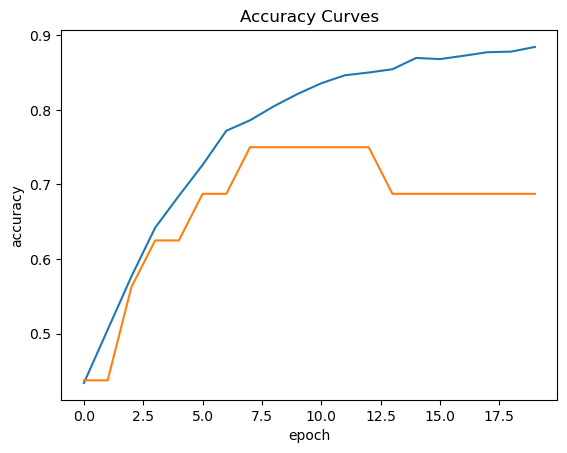

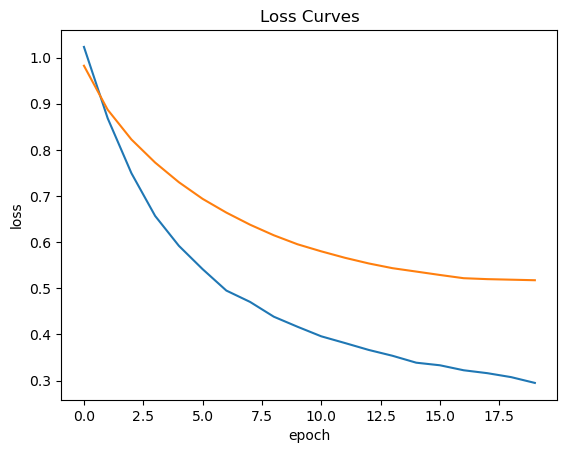

In [4]:
loss_curve_plot(resentV_history)

## Meterics

In [5]:
print(f"Accuracy:",(resentV_model.evaluate(test_data)[1])*100)
print(f"Loss:",(resentV_model.evaluate(test_data)[0])*100)

20/20 [==============================] - 10s 494ms/step - loss: 0.4488 - accuracy: 0.7821
Accuracy: 78.20512652397156
20/20 [==============================] - 7s 343ms/step - loss: 0.4488 - accuracy: 0.7821
Loss: 44.87951695919037


## Confusion Matrix

20/20 [==============================] - 7s 329ms/step


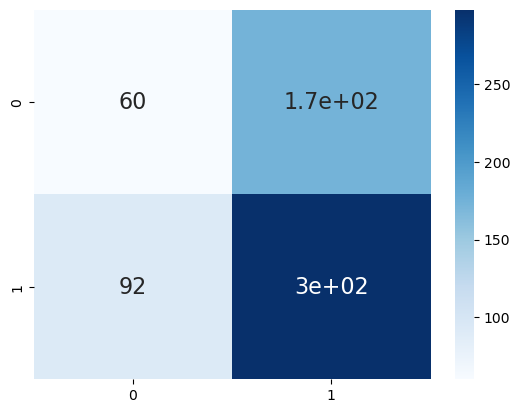

In [6]:
y_true=test_data.classes
y_pred=tf.math.round(resentV_model.predict(test_data))
confusion_matrix_plot(y_true, y_pred)

## VGG16 Model

In [7]:
augmenter=ImageDataGenerator(rescale=1./255)
train_data=augmenter.flow_from_directory(directory=train_path, batch_size=32, target_size = (150,150), class_mode="binary", seed=42, shuffle=True)
test_data=augmenter.flow_from_directory(directory=test_path, batch_size=32, class_mode="binary", target_size = (150,150), seed=42, shuffle=True)
val_data=augmenter.flow_from_directory(directory=val_path, batch_size=32, class_mode="binary", target_size = (150,150), seed=42, shuffle=True)

vgg16_base=tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='avg',
    classifier_activation='sigmoid'
)

vgg16_model=Sequential()
vgg16_model.add(vgg16_base)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(50, activation="relu"))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.7))
vgg16_model.add(Dense(150, activation="relu"))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dense(50, activation="relu"))
vgg16_model.add(Dropout(0.7))
vgg16_model.add(Dense(1, activation="sigmoid"))

vgg16_model.summary()

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 50)                0        

In [8]:
#Callbacks
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 4)

#Comiple and fit resnetV_model
vgg16_model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(lr=0.00001, decay=1e-6), metrics=["accuracy"])
vgg16_history = vgg16_model.fit(x=train_data, validation_data=val_data, steps_per_epoch = len(train_data), epochs = 20, callbacks=[checkpointer, early_stopping])

#Meterics
print(f"Accuracy:",(vgg16_model.evaluate(test_data)[1])*100)

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 1.0970 - accuracy: 0.4705
Epoch 1: val_loss improved from inf to 0.64370, saving model to chestmodel.hdf5
163/163 [==============================] - 76s 441ms/step - loss: 1.0970 - accuracy: 0.4705 - val_loss: 0.6437 - val_accuracy: 0.8125
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 0.8822 - accuracy: 0.5579
Epoch 2: val_loss improved from 0.64370 to 0.49323, saving model to chestmodel.hdf5
163/163 [==============================] - 70s 431ms/step - loss: 0.8822 - accuracy: 0.5579 - val_loss: 0.4932 - val_accuracy: 1.0000
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.7601 - accuracy: 0.6039
Epoch 3: val_loss did not improve from 0.49323
163/163 [==============================] - 69s 423ms/step - loss: 0.7601 - accuracy: 0.6039 - val_loss: 0.5790 - val_accuracy: 0.7500
Epoch 4/20
163/163 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.6382
Epo

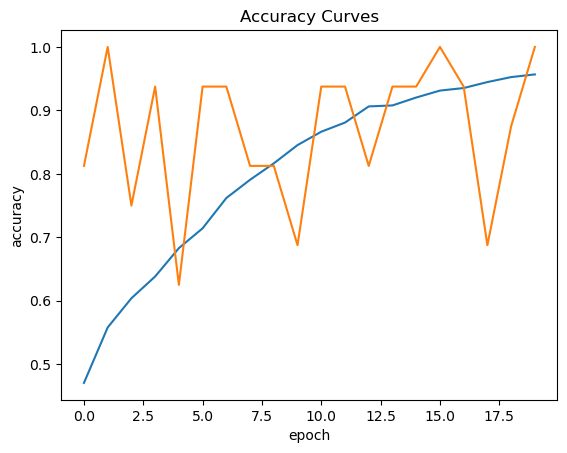

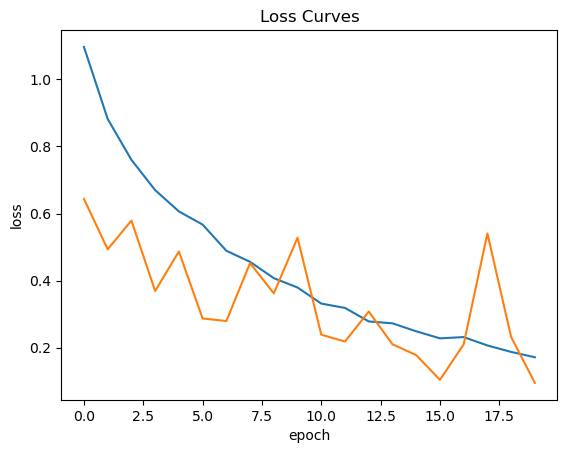

In [9]:
loss_curve_plot(vgg16_history)

20/20 [==============================] - 7s 361ms/step


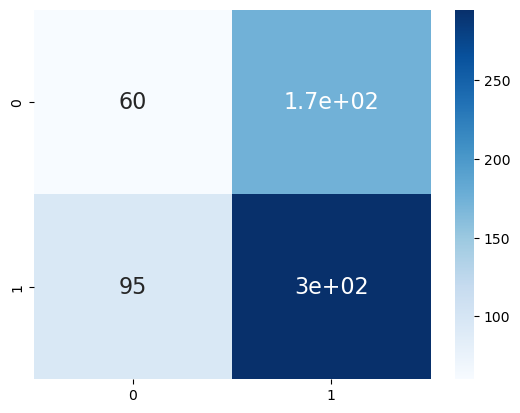

In [10]:
y_true=test_data.classes
y_pred=tf.math.round(vgg16_model.predict(test_data))
confusion_matrix_plot(y_true, y_pred)